# 初期化

- S&P500と有名な高配当投資信託の相関を計算する
    - 単純相関は，色々分析されているが，トレンドと変動を分離して変動の相関を取りたい
- リスクリターン計算の参考サイト
    - https://note.com/yo4shi80/n/na99fa1f996a1

In [1]:
import toml
import pandas as pd
import datetime
import copy
import numpy as np

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

from pptx import Presentation
from pptx.util import Cm, Pt, Inches  # 単位変換機能
from pptx.dml.color import RGBColor   # 色指定用

from deal import *

In [2]:
labels = [  'VOO'  # S&P500 連動 ETF
          , 'SPYD' # S&P500 高配当株式 ETF
          , 'VYM'  # バンガード米国高配当株式 ETF
          , 'SCHD' # シュワブ米国高配当株式 ETF
          , 'VT'   # バンガード・トータル・ワールドストックETF
          , 'GLD'  # SDPRゴールドシェア
         ]

In [3]:
tickers = {key: yf.Ticker(key) for key in labels}
data = {}
for key,ticker in tickers.items():
    datum = ticker.history(start='2000-01-01', end='2025-02-21')
    datum.index = datum.index.tz_localize(None)
    data[key] = datum
close_list = []
dividends_list = []
key_list = []
for key, datum in data.items():
    close_list.append(datum['Close'])
    dividends_list.append(datum['Dividends'])
    key_list.append(key)
# 終値の時系列
close_df = pd.concat(close_list, axis=1, join='inner')
close_df.columns = key_list

# 分配金の時系列
dividends_df = pd.concat(dividends_list, axis=1, join='inner')
dividends_df.columns = key_list

# 分配金の額面に対する率
div_rate_df = dividends_df/close_df

# 関数群

In [4]:
def get_dividends(close_df, div_df, t):
    return div_df.loc[t].fillna(0)/close_df.loc[t]  # 額面に対する分配金額の率

In [5]:
def rebalance_judge(assets, portfolio, threshold = 1):
    '''リバランスするか判断する

    Parameters
    ----------
    assets : pandas.Series
        資産時系列のDataFrameのうち，ジャッジしたい時刻インデックスのスライス
        資産が N 個の時，assets.shape == (1, N)
    portfolio : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの

    Result
    ------
    buy_rate : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの
        今回購入の比率

    '''
    rate = assets/assets.sum()  # 資産割合
    diff = (rate-portfolio)*100  # 乖離
    if diff.abs().max() > threshold:
        return True
    else:
        return False

## 移行済関数

def buy_fund(target_df, t):
    '''時刻 t の価額を1とした場合の正規化時系列を返却
    '''
    tmp_df = target_df[target_df.index >= t]
    return tmp_df/tmp_df.head(1).values

def rebalance_buy(assets, portfolio, buy_amount = 1):
    '''購入結果がportfolioの比になるよう購入額を調整する

    Parameters
    ----------
    assets : pandas.Series
        資産時系列のDataFrameのうち，リバランスしたい時刻インデックスのスライス
        資産が N 個の時，assets.size == N
    portfolio : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの

    Result
    ------
    buy_rate : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの
        今回購入の比率
    '''

    #assets = assets.iloc[0]  # pandas.Seriesに変換
    total = assets.sum() + buy_amount
    delta = total*portfolio - assets
    # 負になっているものがある場合、売却になってしまうので0にし、他の資産の購入に均等配分
    delta[delta<0] = 0
    delta = delta/delta.sum()
        
    return delta

TAX_RATE=0.20315

def rebalance(assets, principle, portfolio):
    '''リバランスをちゃんとやるための関数
    この関数が呼ばれた時点で，リバランス条件を満たしており，この関数はportfolioにピッタリ合わせることを目的とする
    本当は、売却益の TAX_RATE とするべきだが、現状は売却総額の TAX_RATEになっている

    Parameters
    ----------
    assets : pandas.Series
        資産時系列のDataFrameのうち，リバランスしたい時刻インデックスのスライス
        資産が N 個の時，assets.size == N
    principle : pandas.Series
        元本
    portfolio : pandas.Series
        columns が資産時系列の名前, value がその資産のウェイトであり正規化済のもの
    '''

    t = assets.name

    # 利益率計算
    benefit = assets-principle
    bene_rate = (assets/principle-1)

    # 逆比の差
    r2x1_r1x2 = portfolio.iloc[1]*assets.iloc[0] - portfolio.iloc[0]*assets.iloc[1]

    if r2x1_r1x2>0:
        # 1の資産を売って2の資産を買う
        if benefit.iloc[0]>0:
            # 利益が出てたら税金を考慮して売却額を決定
            dx1 = r2x1_r1x2/(1-portfolio.iloc[0]*TAX_RATE*benefit.iloc[0]/assets.iloc[0])  # 売却額
            tax = benefit.iloc[0]*dx1/assets.iloc[0]*TAX_RATE  # 税額
            dx2 = dx1 - tax  # 税引き後受け渡し額=購入額

            sell_buy = pd.Series([-dx1,dx2],name=t)
        else:
            # 利益が出てない時は税金を無視して売却額を決定
            tax = 0
            sell_buy = pd.Series([-r2x1_r1x2,r2x1_r1x2],name=t)
        sell_buy.index=assets.index
    else:
        # 2の資産を売って1の資産を買う
        if benefit.iloc[1]>0:
            # 利益が出てたら税金を考慮して売却額を決定
            dx2 = -r2x1_r1x2/(1-portfolio.iloc[1]*TAX_RATE*benefit.iloc[1]/assets.iloc[1])  # 売却額
            tax = benefit.iloc[1]*dx2/assets.iloc[1]*TAX_RATE  # 税額
            dx1 = dx2 - tax  # 税引き後受け渡し額=購入額

            sell_buy = pd.Series([dx1,-dx2],name=t)
        else:
            # 利益が出てない時は税金を無視して売却額を決定
            tax = 0
            sell_buy = pd.Series([-r2x1_r1x2,r2x1_r1x2],name=t)
        sell_buy.index=assets.index

    return sell_buy, tax.sum()

# テストコード

- [x] 各時系列毎にトレンドを分離するために seasonal_decompose などを利用する
    - [x] 周期を決めるためにgroupbyでレコード数をカウントする
- [x] トレンドとの残差成分の相関を計算する
- [x] 分配金追加のリターンも計算する
- [x] 分配金再投資のリターンも計算する

In [4]:
ticker = yf.Ticker('VOO')
datum = ticker.history()  # 1ヶ月しか取得してくれない
display(datum)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-02-05 00:00:00-05:00,552.340027,555.729980,550.409973,555.619995,3424200,0.0,0.0,0.0
2025-02-06 00:00:00-05:00,557.289978,557.650024,554.190002,557.619995,3606300,0.0,0.0,0.0
2025-02-07 00:00:00-05:00,558.099976,559.200012,551.789978,552.200012,10161600,0.0,0.0,0.0
2025-02-10 00:00:00-05:00,555.440002,556.780029,554.239990,556.150024,3517600,0.0,0.0,0.0
2025-02-11 00:00:00-05:00,554.099976,557.119995,553.989990,556.650024,2752900,0.0,0.0,0.0
2025-02-12 00:00:00-05:00,551.000000,555.919983,550.390015,554.809998,3579500,0.0,0.0,0.0
2025-02-13 00:00:00-05:00,555.869995,560.880005,554.700012,560.669983,3388500,0.0,0.0,0.0
2025-02-14 00:00:00-05:00,560.900024,561.859985,560.070007,560.690002,3380600,0.0,0.0,0.0
2025-02-18 00:00:00-05:00,561.799988,562.309998,559.489990,562.309998,3844900,0.0,0.0,0.0


In [11]:
ticker.history(start=datetime.datetime(2000,1,1),end=None)  # startは文字列 'yyyy-mm-dd' でも datetime.datetime でも OK

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-09-09 00:00:00-04:00,78.626516,78.626516,77.583276,77.721352,26500,0.0,0.0,0.0
2010-09-10 00:00:00-04:00,77.997458,78.135534,77.705967,78.074165,8600,0.0,0.0,0.0
2010-09-13 00:00:00-04:00,78.979353,79.117429,78.626494,79.056061,33750,0.0,0.0,0.0
2010-09-14 00:00:00-04:00,78.887312,79.378254,78.534453,79.040733,59400,0.0,0.0,0.0
2010-09-15 00:00:00-04:00,78.718569,79.301551,78.549808,79.240189,9250,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-02-26 00:00:00-05:00,548.010010,551.349976,544.250000,546.750000,4180800,0.0,0.0,0.0
2025-02-27 00:00:00-05:00,548.830017,549.880005,537.599976,537.969971,5521400,0.0,0.0,0.0
2025-02-28 00:00:00-05:00,538.419983,546.890015,535.580017,546.330017,7328100,0.0,0.0,0.0


In [15]:
datum.index.tz_localize(None)

DatetimeIndex(['2025-02-05', '2025-02-06', '2025-02-07', '2025-02-10',
               '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14',
               '2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21',
               '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27',
               '2025-02-28', '2025-03-03', '2025-03-04'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:

for key,ticker in tickers.items():
    datum = ticker.history(start='2000-01-01', end='2025-02-21')
    datum.index = datum.index.tz_localize(None)
    data[key] = datum
close_list = []
dividends_list = []
key_list = []
for key, datum in data.items():
    close_list.append(datum['Close'])
    dividends_list.append(datum['Dividends'])
    key_list.append(key)
# 終値の時系列
close_df = pd.concat(close_list, axis=1, join='inner')
close_df.columns = key_list

# 分配金の時系列
dividends_df = pd.concat(dividends_list, axis=1, join='inner')
dividends_df.columns = key_list

# 分配金の額面に対する率
div_rate_df = dividends_df/close_df

### テストのための中間データ

In [ ]:
# 終値を時系列の先頭の終値で正規化した相対時系列
relative_close_df = close_df/close_df.loc[close_df.index[0]]
# 分配金を時系列の先頭の終値で正規化した相対時系列
relative_div_df = dividends_df/close_df.loc[close_df.index[0]]
# 分配金の累積関数
relative_div_cumsum_df = relative_div_df.cumsum()
#relative_close_df.plot()
#relative_div_df.plot()
#relative_div_cumsum_df.plot()

## キャピタルゲイン+分配金累計額 (非投資)

In [5]:
# 分配金追加のリターン
relative_close_and_div = relative_close_df+relative_div_cumsum_df
#relative_close_and_div.plot()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
# 分配金有無の確認
relative_div_df.sum()

VOO     0.310676
SPYD    0.772348
VYM     0.533663
SCHD    0.344347
VT      0.346171
GLD     0.000000
dtype: float64

## 分配金再投資

### テストコード

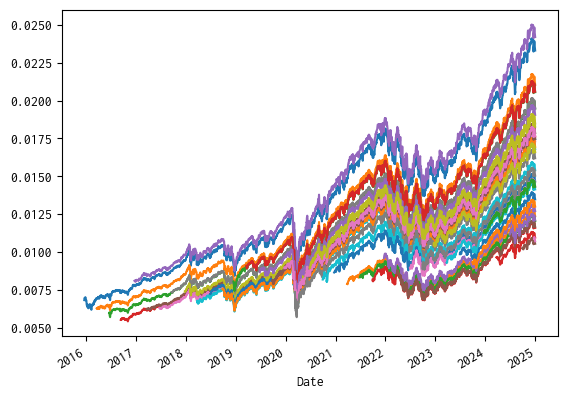

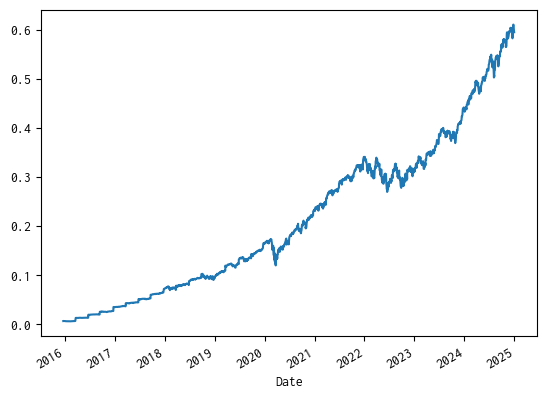

In [22]:
# 分配金再投資のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
for dt in divs.keys():
    divs[dt].plot()
plt.show()
plt.close('all')

# 分配金再投資の合計のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
pd.DataFrame(divs).sum(axis=1).plot()
plt.show()
plt.close('all')

### 分配金再投資系列の作成

<Axes: >

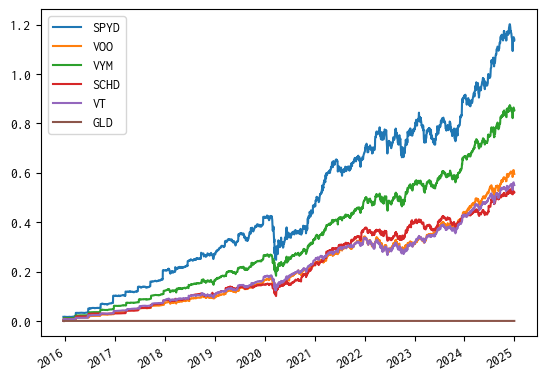

In [8]:
temporal_data = {}
for key in key_list:
    divs = {}
    # 分配金受取時の基準価額を1.0とした相対価額時系列に分配金を乗算する
    for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
        divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
    # 分配金受取時ごとの系列をDataFrame型に変換し全て加算する
    temporal_data[key] = pd.DataFrame(divs).sum(axis=1)
# 分配金運用額のみのデータ
divid_reinvest_df = pd.DataFrame({key:value for key, value in sorted(temporal_data.items(), key=lambda x: min(x[1].index) if x[1].size > 0 else datetime.datetime(2099,1,1))}).fillna(0)
divid_reinvest_df.plot()

<Axes: >

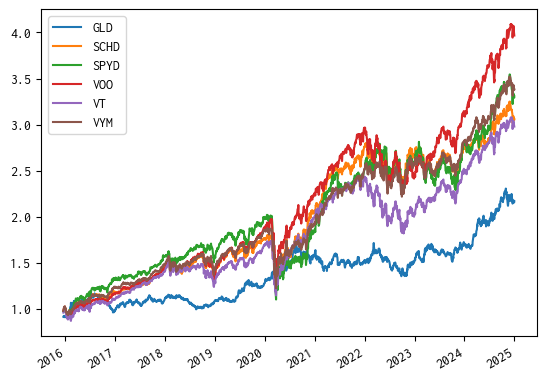

In [9]:
# キャピタルゲイン+分配金
relative_close_and_div_reinvest = relative_close_df + divid_reinvest_df
relative_close_and_div_reinvest.plot()

# 傾向分析

トレンドは同じく右上がりだが，季節性や残差が無相関の系列を探したい

- [x] 分配金再投資系列を，集計範囲のみに削ってから，元のETF相対時系列に足したトータルリターンのグラフを作成する
- [x] 分配金再投資系列をトレンドと季節制変動に分解する
- [x] 季節性，残差の相関を計算する
- [ ] 年推移相関係数をプロットする
- [ ] リスク・リターン平面でシャープレシオを最小化する比率の計算

## 配当金再投資系列の作成

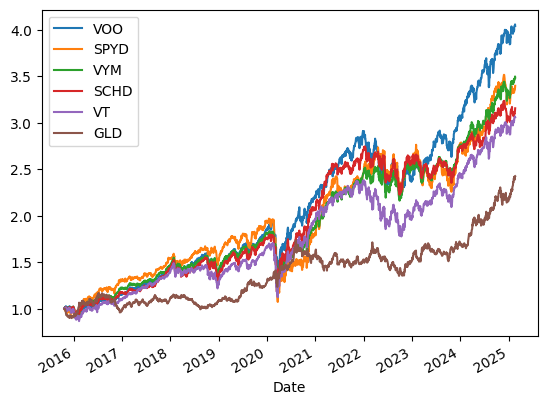

In [70]:
timestamps = close_df.index
reinvest_ts = buy_fund(close_df, timestamps[0])  # 時系列の最初に1ドル投資した場合の時系列

for t, v in div_rate_df.iterrows():
    if v.sum()>0:
        reinvest_ts = reinvest_ts.add(buy_fund(close_df, t) * v * reinvest_ts.loc[t] * (1-TAX_RATE), fill_value=0)

reinvest_ts.plot()
plt.show()

## 時系列の季節性分離

In [44]:
analized = {col:seasonal_decompose(ts, period=251) for col, ts in reinvest_ts.items()}

### 形状確認:トレンド，季節性，残差の出力

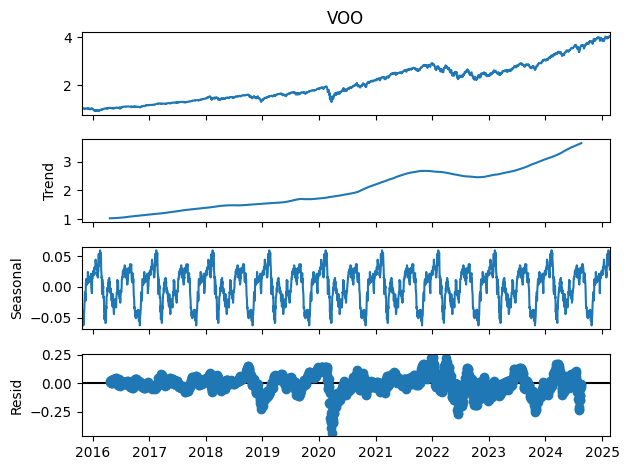

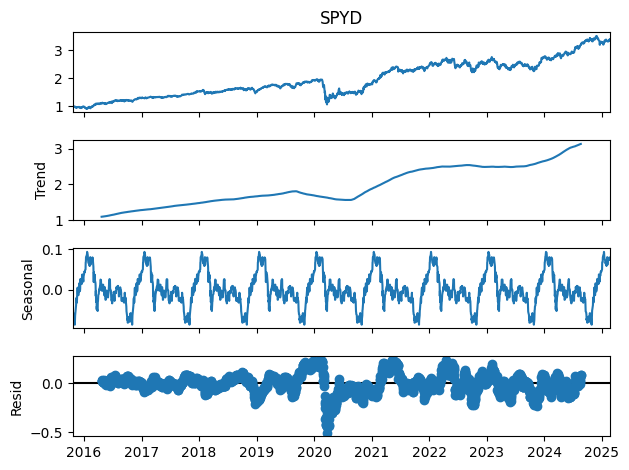

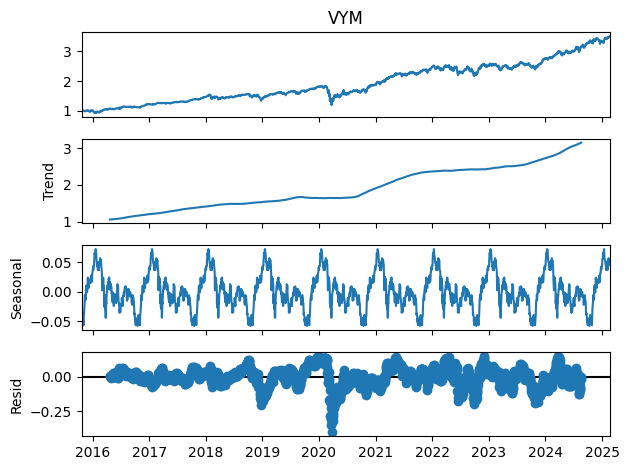

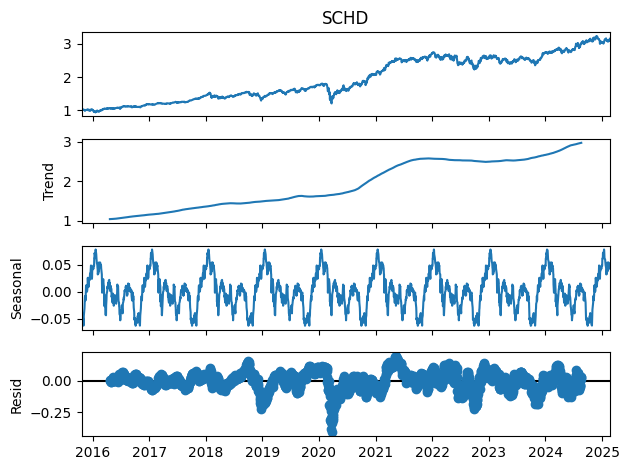

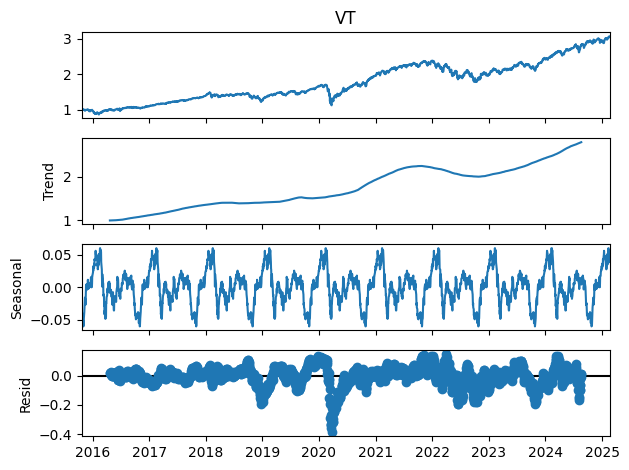

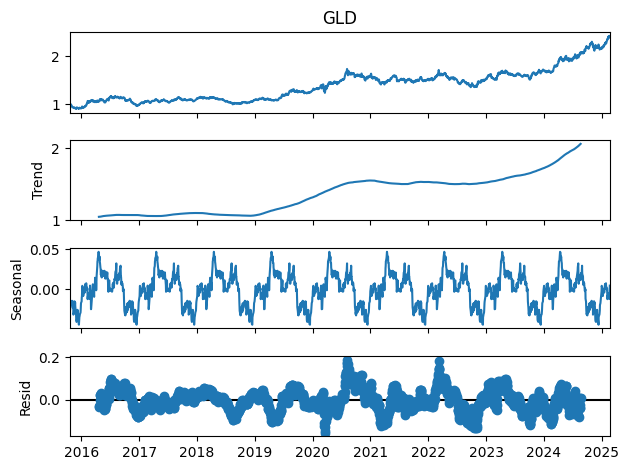

In [47]:
for ticker, anal in analized.items():
    anal.plot()
    plt.show()

## 時系列そのまま相関分析

以下の通り，GLDといえでもインフレトレンドは共通でトレンド成分を除去しない相関行列は高い値を示す  
VOOとVTが，VOOと他の高配当投信とほとんど相関に差がないこと，GLDとも差がないことから，
後述の分析と合わせて考えれば，インフレ傾向がトレンドに大きく寄与しており，季節性や残差の影響はトレンドと比較して小さいことが分かる

### ペアプロット

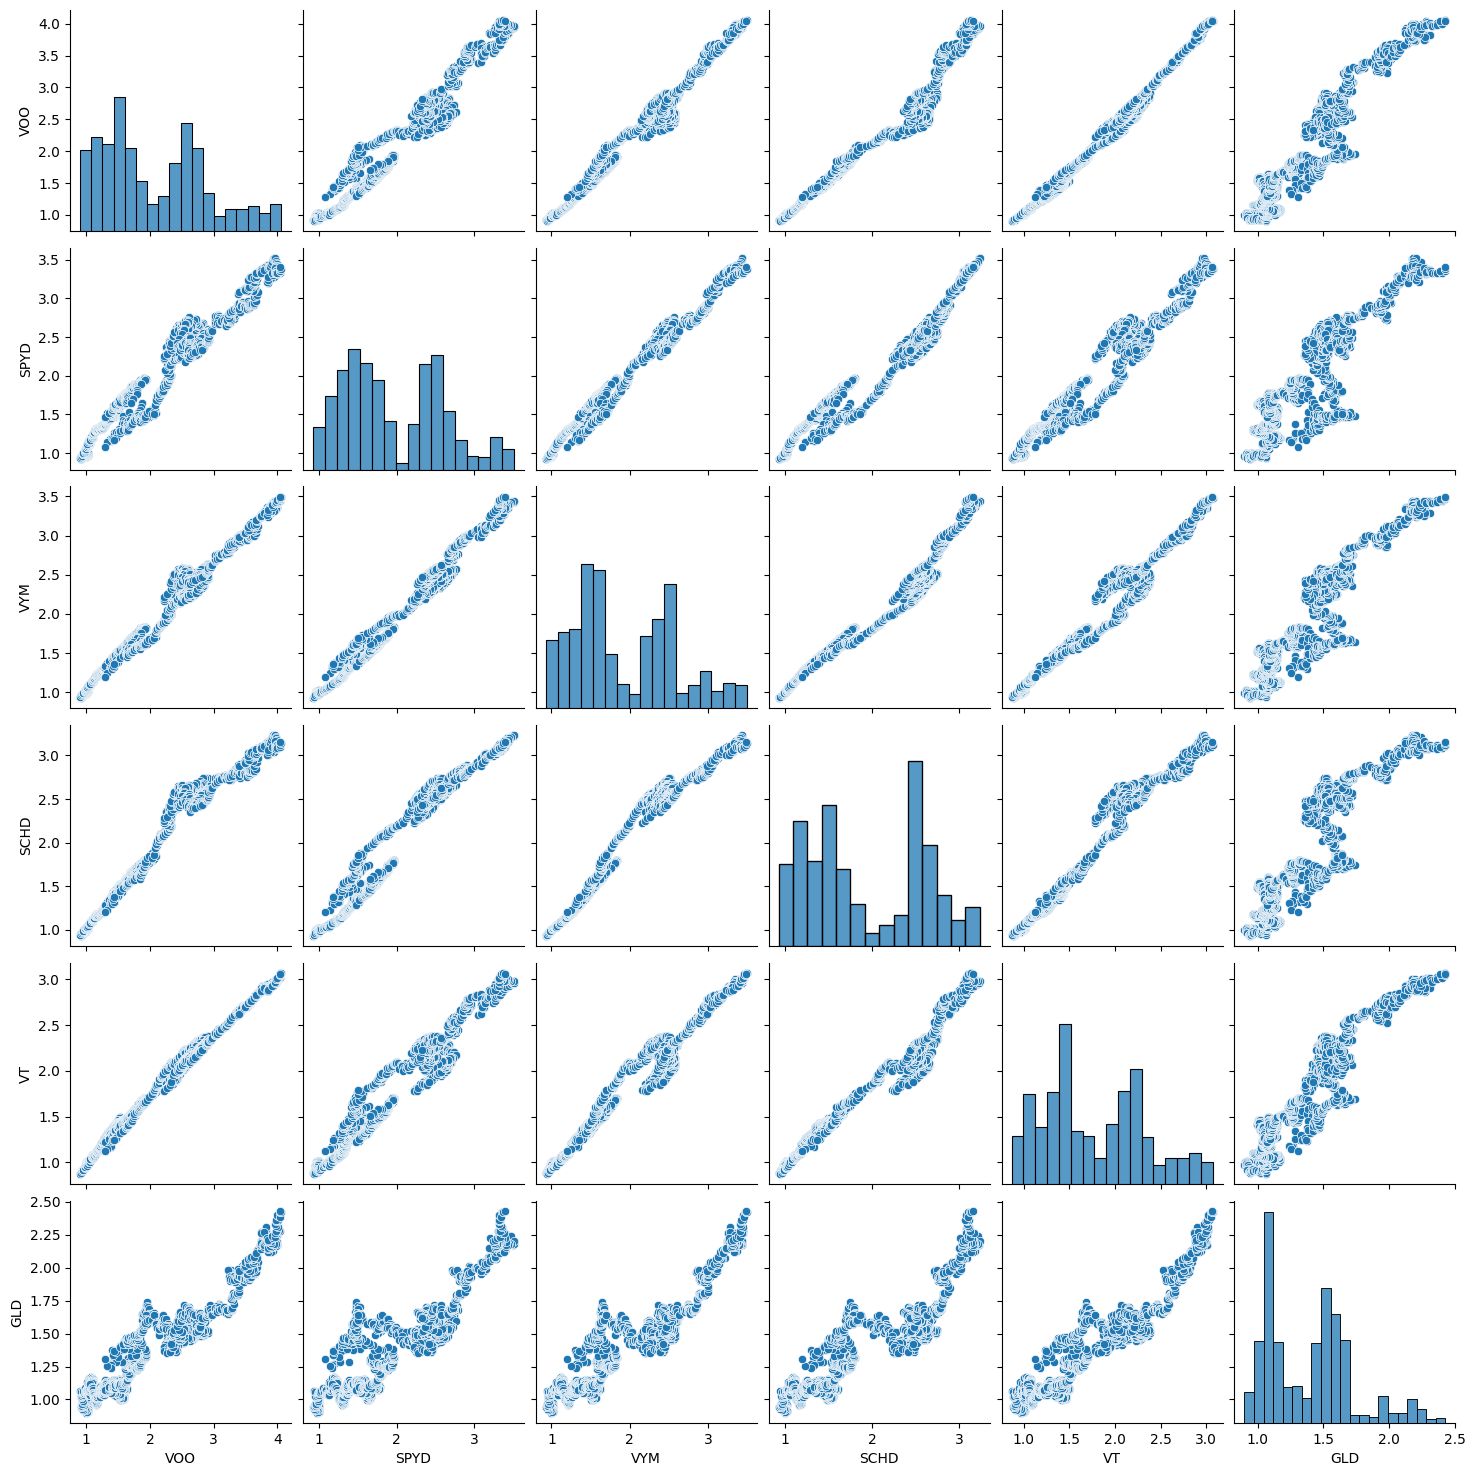

In [49]:
sns.pairplot(reinvest_ts)
plt.show()

### 相関行列

In [50]:
reinvest_ts.corr()

,VOO,SPYD,VYM,SCHD,VT,GLD
VOO,1.000000,0.969014,0.989410,0.977828,0.995215,0.945354
SPYD,0.969014,1.000000,0.990345,0.973738,0.964765,0.882194
VYM,0.989410,0.990345,1.000000,0.982419,0.982139,0.921816
SCHD,0.977828,0.973738,0.982419,1.000000,0.980592,0.901412
VT,0.995215,0.964765,0.982139,0.980592,1.000000,0.932390
GLD,0.945354,0.882194,0.921816,0.901412,0.932390,1.000000


## 季節性成分のみ抽出して相関分析

季節性も共通点が多いかと思いきや，意外とGLDは他の株式関係の投信とかなり相関が低い  
また，VOOとVTは他の高配当投信と比較してもかなり相関が高いことから，S&P500とACWIの構成の類似性が相関に出ているように思われる

### ペアプロット

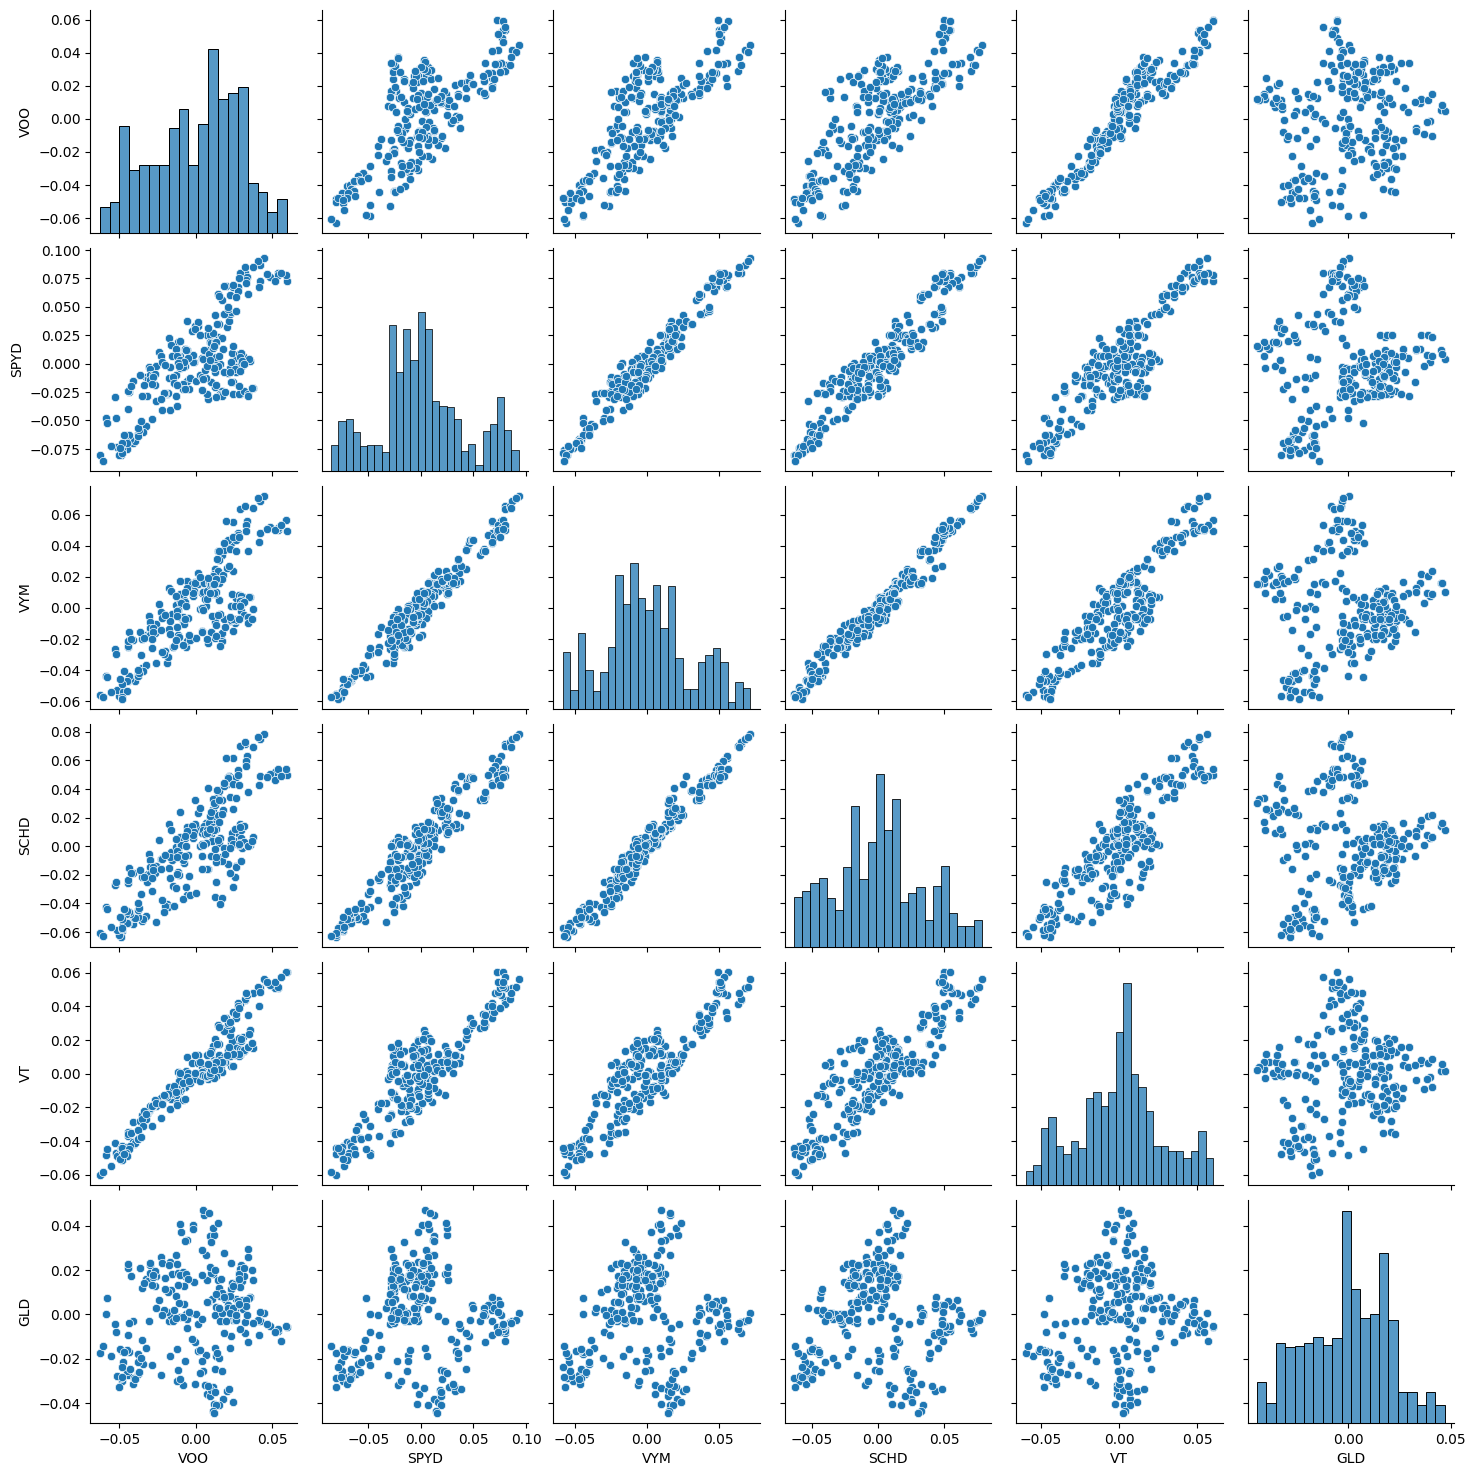

In [52]:
seasonal = pd.DataFrame({col:anal.seasonal for col,anal in analized.items()})
sns.pairplot(seasonal)
plt.show()

### 相関行列

In [53]:
seasonal.corr()

,VOO,SPYD,VYM,SCHD,VT,GLD
VOO,1.000000,0.766289,0.802547,0.796275,0.952820,0.141363
SPYD,0.766289,1.000000,0.974571,0.944479,0.899698,0.119665
VYM,0.802547,0.974571,1.000000,0.982872,0.902688,0.077389
SCHD,0.796275,0.944479,0.982872,1.000000,0.874247,0.050528
VT,0.952820,0.899698,0.902688,0.874247,1.000000,0.164205
GLD,0.141363,0.119665,0.077389,0.050528,0.164205,1.000000


## 残差のみ抽出して相関分析

残差はトレンドと自己回帰成分を除去した残差であるので，突発的な変動が残っていると考えられる  
要するにトレンドは株・コモディティに共通する変動で，通貨の価値の低減に関する変動と思われる  
季節成分は株式とコモディティのGLDとの相関が非常に小さく，しかし株式の投信間では高い相関を示すことから，株式市場に特有のシステマティックリスクと思われる  

これらと比較して，残差は非システマティックリスクだと考えていた  
しかしながら米国投信のVOO,SPYD,VYM,SCHDとVTの相関は季節性の成分より相関係数が小さくはあるものの，相関が低いとは言えない値となった  
このことは，上記の米国投信が既にある程度の分散をしている可能性，株式においては非システマティックリスクは対して大きくない可能性，のいずれもありえる

### ペアプロット

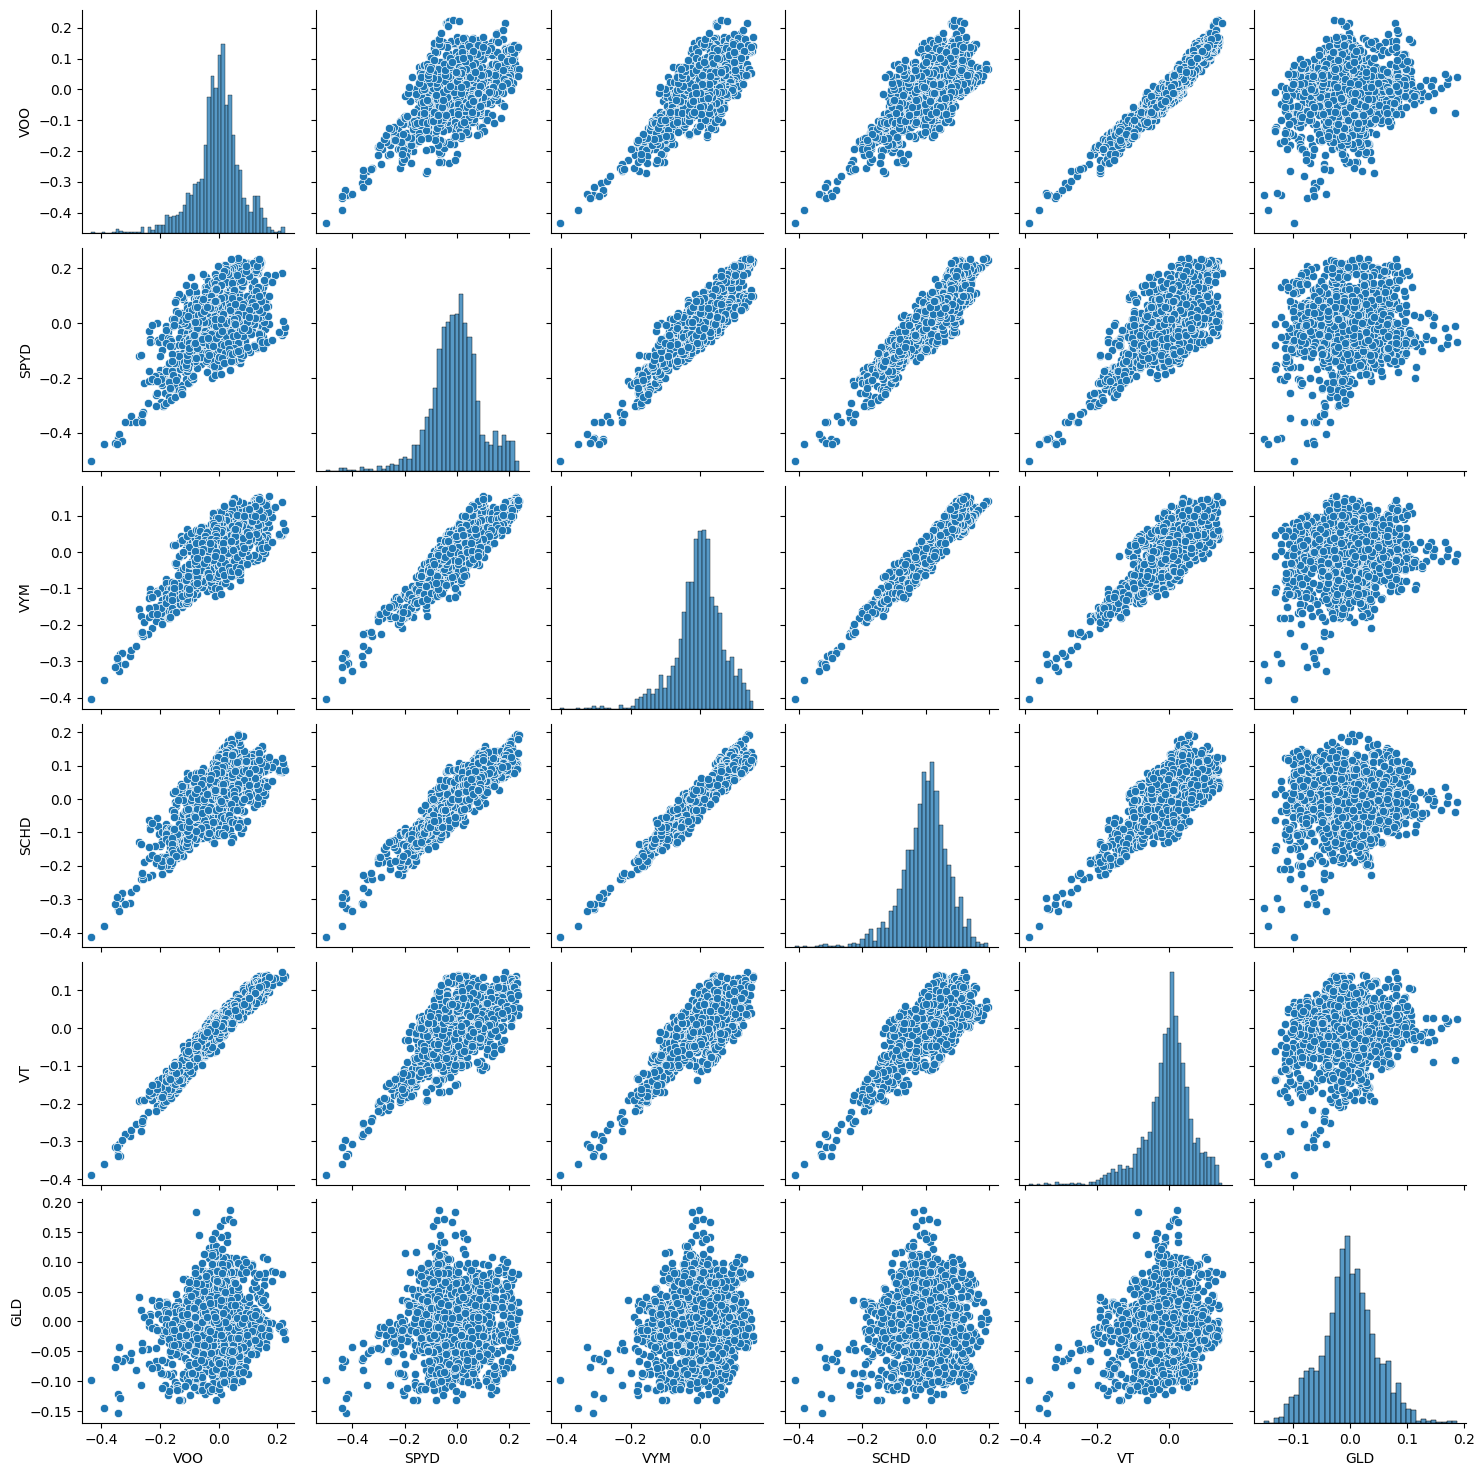

In [55]:
resid = pd.DataFrame({col:anal.resid for col,anal in analized.items()})
sns.pairplot(resid)
plt.show()

### 相関行列

In [56]:
resid.corr()

,VOO,SPYD,VYM,SCHD,VT,GLD
VOO,1.000000,0.638817,0.818925,0.768158,0.961547,0.086658
SPYD,0.638817,1.000000,0.906434,0.901131,0.718513,0.048962
VYM,0.818925,0.906434,1.000000,0.959701,0.851654,0.099131
SCHD,0.768158,0.901131,0.959701,1.000000,0.802623,0.082875
VT,0.961547,0.718513,0.851654,0.802623,1.000000,0.137809
GLD,0.086658,0.048962,0.099131,0.082875,0.137809,1.000000


## セクター別投信の分析

米国の主要ETFで半導体，小型株，ヘルケアで同様に分析してみたところ，  
時系列そのものの相関は高く  
季節性と残差は時系列全体の相関と比較すると小さかった  
特にSOXとVHTの残差は，相関が小さいと言える程度 (0.4～0.5) の相関係数だったので  
とりあえず残差が非システマティックリスクと言っても良いかも知れない

In [74]:
test_labels = ['SOXX', 'IWM', 'VHT']
# 半導体指数 ETF SOXX (SOX)
# 小型株指数 ETF IWM (Russell 2000)
# バイオ・ヘルスケア ETF VHT

In [75]:
test_tickers = {key: yf.Ticker(key) for key in test_labels}
data = {}
for key,ticker in test_tickers.items():
    datum = ticker.history(start='2000-01-01', end='2025-02-21')
    datum.index = datum.index.tz_localize(None)
    data[key] = datum
close_list = []
dividends_list = []
key_list = []
for key, datum in data.items():
    close_list.append(datum['Close'])
    dividends_list.append(datum['Dividends'])
    key_list.append(key)
# 終値の時系列
test_close_df = pd.concat(close_list, axis=1, join='inner')
test_close_df.columns = key_list

# 分配金の時系列
test_dividends_df = pd.concat(dividends_list, axis=1, join='inner')
test_dividends_df.columns = key_list

# 分配金の額面に対する率
test_div_rate_df = dividends_df/close_df

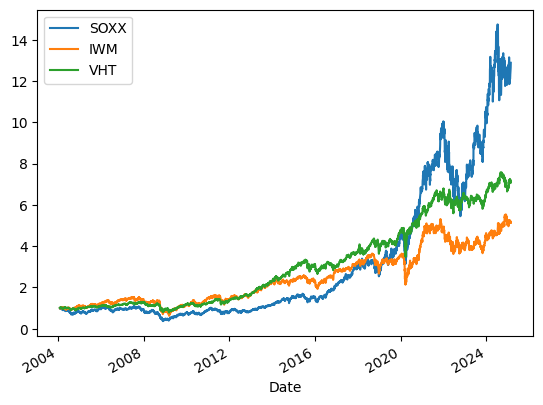

In [76]:
timestamps = test_close_df.index
test_reinvest_ts = buy_fund(test_close_df, timestamps[0])  # 時系列の最初に1ドル投資した場合の時系列

for t, v in test_div_rate_df.iterrows():
    if v.sum()>0:
        reinvest_ts = reinvest_ts.add(buy_fund(test_close_df, t) * v * test_reinvest_ts.loc[t] * (1-TAX_RATE), fill_value=0)

test_reinvest_ts.plot()
plt.show()

In [77]:
analized = {col:seasonal_decompose(ts, period=251) for col, ts in test_reinvest_ts.items()}

### そのまま相関分析

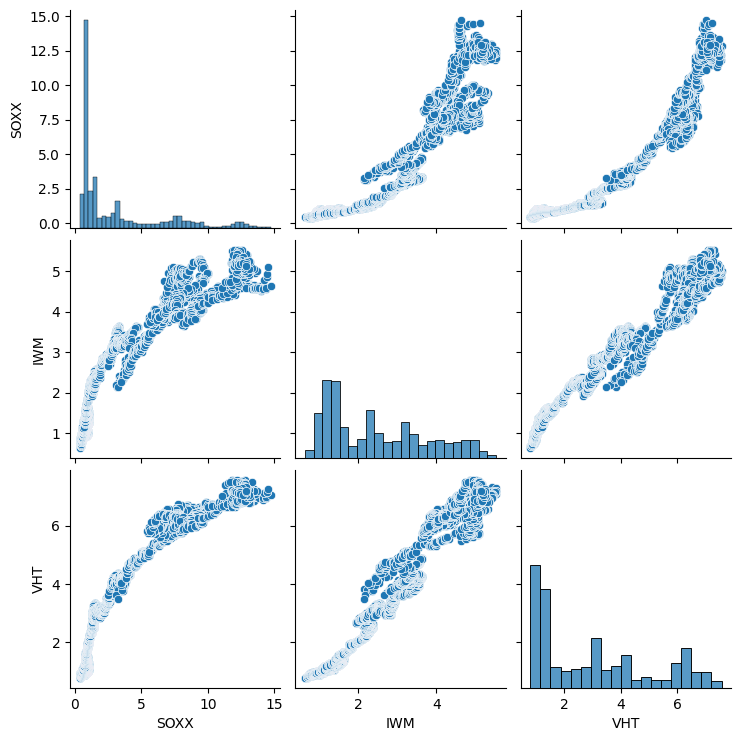

,SOXX,IWM,VHT
SOXX,1.000000,0.908814,0.933155
IWM,0.908814,1.000000,0.981436
VHT,0.933155,0.981436,1.000000


In [80]:
sns.pairplot(test_reinvest_ts)
plt.show()
test_reinvest_ts.corr()

### 季節性のみ

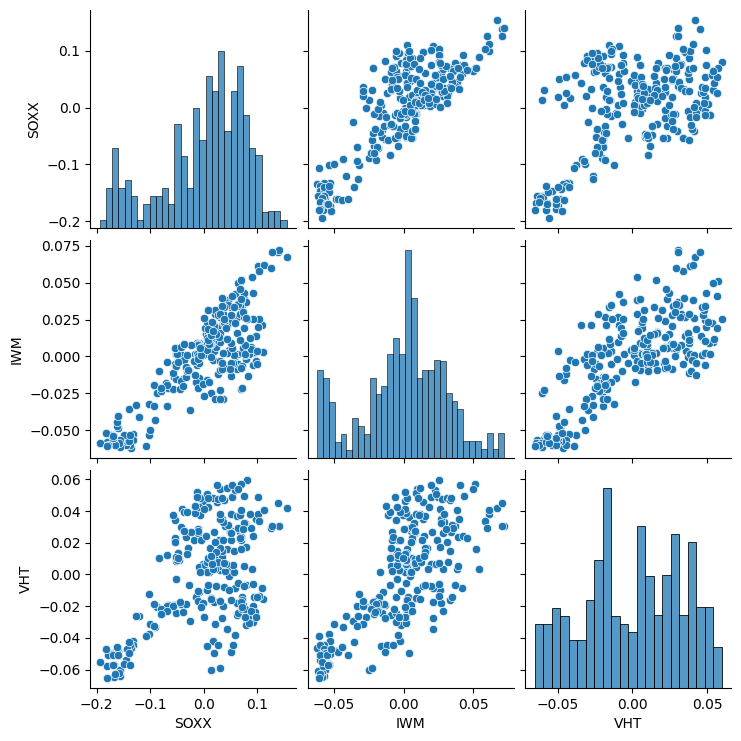

,SOXX,IWM,VHT
SOXX,1.000000,0.822728,0.547148
IWM,0.822728,1.000000,0.730307
VHT,0.547148,0.730307,1.000000


In [81]:
seasonal = pd.DataFrame({col:anal.seasonal for col,anal in analized.items()})
sns.pairplot(seasonal)
plt.show()
seasonal.corr()

### 残差のみ

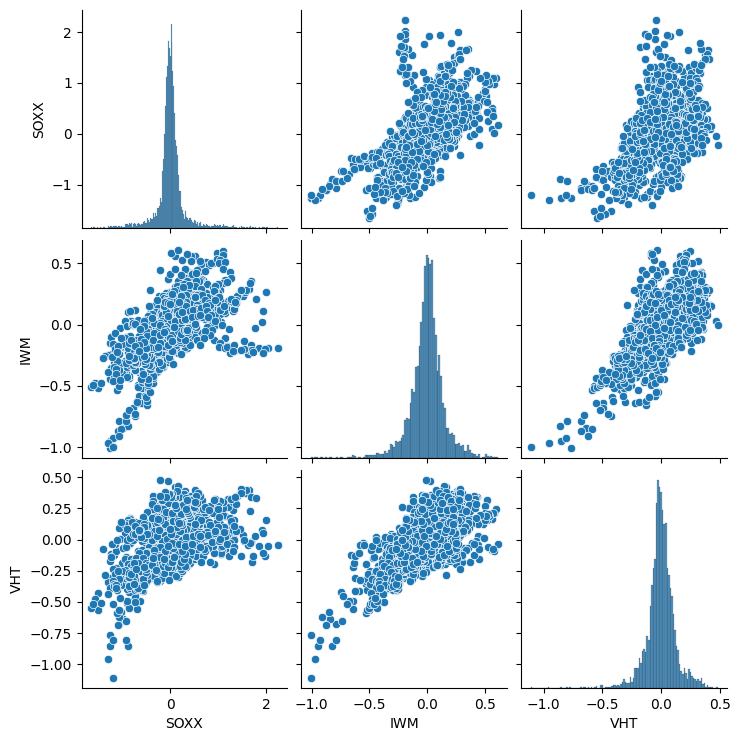

,SOXX,IWM,VHT
SOXX,1.000000,0.581582,0.466425
IWM,0.581582,1.000000,0.667677
VHT,0.466425,0.667677,1.000000


In [82]:
resid = pd.DataFrame({col:anal.resid for col,anal in analized.items()})
sns.pairplot(resid)
plt.show()
resid.corr()

# レポーティング

## レポート条件の設定

### オルカン1本と、オルカン+他資産のPFの比較

- 投資頻度
    - 月1回 定額積立 1円
    - 年初1回 定額積立 12円
    - 当初1回 120円
- 投資銘柄
    - VT
    - VT, GLD
- リバランス条件
    - なし
    - PFからの乖離ポイント 1pt
    - PFからの乖離ポイント 10pt
- リバランス頻度
    - 年1回
    - 年2回
    - 年4回
- リバランス方法
    - 解約&買付 (リバランス頻度のタイミングで目標PFを目指して利益確定&購入)
    - ノーセル (定額買い付け時に常に目標PFを目指した配分で買い付け)

In [15]:
TAX_RATE = 0.20315

# 3以上の資産をリバランスするには、再帰計算する方が手っ取り早いので、税額計算をして売却額を調整して…を繰り返す

def calc_tax(assets, principle, sell, verbose=False):
    '''ある額を売った場合の税額を計算する

    Parameters
    ----------
    assets : pandas.Series
        資産時系列の DataFrame のうち、売却したい時刻インデックスのrowをSeries化したもの
        index が資産名 values が資産の額、name が時刻インデックス
        資産がN個の時 assets.size == N
    principle : pandas.Series
        元本
    sell : pandas.Series
        index が時系列の名前, value がその資産のウエイトであり正規化済の比率
    '''
    benefit = assets-principle
    tax = benefit * sell / assets * TAX_RATE

    return tax

## リバランス

### 考え方

- 計算条件:
    - まず，購買額でリバランスを目指す
    - それでも解消しない場合には売買によるリバランスをする
    - 条件でのリバランス月は，売買リバランスをする月の指定
    - ノーセルリバランスは常に行う
    - 売買リバランスは，目標ポートフォリオと自ポートフォリオの乖離を計算し，閾値を越えた場合にリバランスする
    - この関数では超過ウェイトとなった資産を売却し，不足ウェイトの資産を購入する
    - 資産売却時の税率は TAX_RATE とし，2025年現在の日本では 20.315% (申告分離課税)


### リバランスの計算


- 資産が2種類の場合の計算
    - 資産総額をそれぞれ $X_1, X_2$ とする
    - 投資元本をそれぞれ $O_1, O_2$ とする
    - 利益率をそれぞれ $p_1, p_2$ とする、すなわち $X_i = (1+p_i)O_i$ また, $p_1=\frac{X_1}{O_1}-1$である
    - 利益は $X_1-O_1=p_1O_1$
    - ポートフォリオを $r_1, r_2$ とする

- 税率 $r_t$
- 売却額 $\Delta X_1$
- 税金 tax=$p_1O_1\frac{\Delta X_1}{X_1}r_t$
- 税引き後受取額 $\Delta X_{1-}=\Delta X_1-{\rm tax}$
- 購入額=$\Delta X_{1-}=\Delta X_2$

ここで，$\Delta X_1$を求めたい
$$\Delta X_{1-}=\Delta X_1-{\rm tax}=\Delta X_1(1-r_t)$$
リバランス後の資産額の比率が
$$X_1-\Delta X_1:X_2+\Delta X_{1-}=r_1:r_2$$
であることから，
$$(X_1-\Delta X_1)r_2=(X_2+\Delta X_1-{\rm tax})r_1$$
が成立する
$$r_2X_1-r_2\Delta X_1=r_1X_2+r_1\Delta X_1-r_1p_1O_1\frac{\Delta X_1}{X_1}r_t$$
ここで
$$r_1+r_2=1$$
であることから
$$r_2X_1-r_1X_2=(r_1+r_2)\Delta X_1-r_1\Delta X_1\frac{r_1p_1O_1r_t}{X_1}$$
$$r_2X_1-r_1X_2=\Delta X_1\left(1-\frac{r_1p_1O_1r_t}{X_1}\right)$$
さて、ここで $X_1=(1+p_1)O_1$ に注意して
$$\frac{O_1}{X_1}=\frac{1}{1+p_1}$$
より
$$r_2X_1-r_1X_2=\Delta X_1\left(1-\frac{r_1p_1r_t}{1+p_1}\right)$$
以上から
$$\Delta X_1=\frac{r_2X_1-r_1X_2}{1-\frac{r_1p_1r_t}{1+p_1}}$$

## TODO

- [ ] 3資産以上の場合のリバランス
- [x] 実装パターン
    - [x] X1を売るが、X1は利益が出ていて税金がかかる
    - [x] X1を売るが、X1も損失が出ていて税金がかからない
- [x] ノーセルリバランス

### リバランス関数のデバッグコード

before [5.18557318 0.65250002] [0.88823367 0.11176633]
after [5.2532537  0.58369486] [0.9 0.1] 0.0011246486128969242
before [18.21321546  1.78097589] [0.91092534 0.08907466]
after [17.99042094  1.99893566] [0.9 0.1] 0.0048347468064659435
before [88.03272937  8.48951872] [0.91204599 0.08795401]
after [86.79608503  9.64400945] [0.9 0.1] 0.08215360055217628


,VT,GLD
Date,,
2015-10-22,0.9,0.1
2015-10-23,0.0,0.0
2015-10-26,0.0,0.0
2015-10-27,0.0,0.0
2015-10-28,0.0,0.0
...,...,...
2025-02-13,0.0,0.0
2025-02-14,0.0,0.0
2025-02-18,0.0,0.0


,VT,GLD
Date,,
2015-10-22,0.900000,0.100000
2015-10-23,0.908343,0.099830
2015-10-26,0.905613,0.099767
2015-10-27,0.900000,0.099991
2015-10-28,0.907585,0.099185
...,...,...
2025-02-13,174.138301,23.038771
2025-02-14,174.321808,22.696144
2025-02-18,174.999394,23.072013


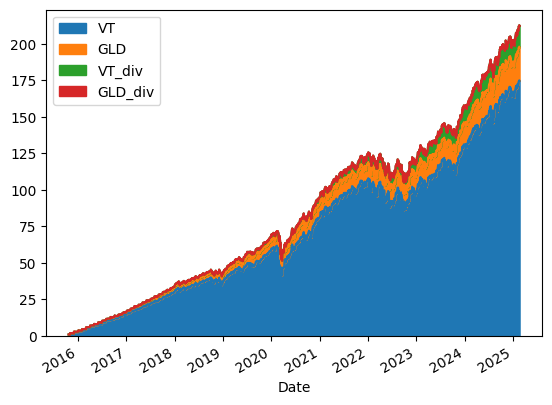

total return is  212.36845971396198


/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_11709/1821694114.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', total.sum(axis=1)[-1])


In [57]:
# デバッグ用データロード
debug = True  # リバランスの前後の変化を出力する

condition = [
    {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , True  # リバランス方法 (True: 解約・買い付け, False: ノーセルリバランスを毎月)
    , 'VT&GLD'  # name
    ]

portfolio = pd.Series(condition[0])
target_close = close_df[portfolio.keys()]
dividends = {}
for ticker in portfolio.keys():
    dividends[ticker] = dividends_df[dividends_df[ticker]>0][ticker]
target_div = pd.DataFrame(dividends)

timestamps = target_close.index
div_timestamps = target_div.index
buy_monthes = condition[1]
portfolio *= condition[2]/portfolio.sum()
threshold = condition[3]
rebalance_monthes = condition[4]
rebalance_method = condition[5]

prev = -1

result = target_close * 0  # 現在資産
buy_history = target_close * 0  # 投資記録
receive_dividends = target_close * 0  # 受け取った分配金
taxes = target_close * 0  # 支払った税金

for t in timestamps:
    if t.month != prev:
        # reset behavior
        bought = False
        rebalanced = False
        prev = t.month
    if t.month in buy_monthes:
        # rebalance_method = False の場合，買い付け額が変更
        if not bought:
            ### 原価を累積する時系列を用意する
            #display('buy history', (buy_fund(target_close, t)*portfolio)[target_close.index==t])
            buy_history.loc[t] += portfolio
            result = result.add(buy_fund(target_close, t)*portfolio, fill_value=0)  # 現在資産に買った投信を加算
            bought = True
    if t.month in rebalance_monthes:
        if not rebalanced:
            if rebalance_judge(result[result.index==t], portfolio, threshold):
                principle = buy_history.cumsum()
                if debug:
                    assets = result[result.index==t].iloc[0]
                    print('before', assets.values, (assets/assets.sum()).values)
                sell_buy, tax = rebalance(result[result.index==t], principle[principle.index==t], portfolio, False)  # リバランスには原価が必要
                result = result.add(buy_fund(target_close, t)*sell_buy, fill_value=0)  # 現在資産に買った投信を加算
                buy_history.loc[t] += sell_buy
                taxes.loc[t] += tax
                if debug:
                    assets = result[result.index==t].iloc[0]
                    print('after', assets.values, (assets/assets.sum()).values, tax)
            else:
                #display('not rebalance')
            rebalanced = True
    if t in div_timestamps:
        # 分配金
        receive_dividends = receive_dividends.add((result*get_dividends(target_close, target_div, t)).dropna(), fill_value=0)

div_df = receive_dividends.cumsum()
div_df.columns = [col + '_div' for col in div_df.columns]
total = pd.concat([result, div_df], axis=1)

display(buy_history[buy_history.index<=t])
display(result[result.index<=t])

total.plot.area()
plt.show()
plt.close('all')

print('total return is ', total.sum(axis=1)[-1])


## シミュレーション条件

In [6]:
# 対象の時系列の終値と分配金の時系列を取得する

conditions = [
    [ {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , 'VT&GLD yearly rebalance'  # name
    ],
    [ {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [1,3,5,7,9,11]  # リバランス頻度 (月のリスト)
    , 'VT&GLD monthly rebalance'  # name
    ],
    [ {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 10  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , []  # リバランス頻度 (月のリスト)
    , 'VT&GLD no rebalance'  # name
    ],
    [ {'VT': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , []  # リバランス頻度 (月のリスト)
    , 'VT'  # name
    ],
]

#close_df      # 終値時系列
#dividends_df  # 分配金時系列

# 投資頻度の実装
## 投資タイミングの日を先頭とした時系列を切り出し、その先頭の値で相対化した正規化時系列を生成し、投資金額で乗じたものを、独立した時系列として生成する
## その時系列を積立期間の最後まで生成し続けリストとし、そのリストの和を取る



## シミュレーション

### 売買でのリバランスの場合

- 結論
    - オルカン9:金1の場合については
        - リバランスなしよりありの方がリターン高
        - リバランスは年1より毎月の方が支払い税額を差し引いてもリターン高い
    - また，ノーセルリバランスは支払い税額を0にできるため，単純に税率分だけリターン向上
    - 以上のことから，ポートフォリオを組む場合はリバランスを組むこと，リバランスはノーセルリバランスとすること，が最良と考えられ，売買のみでリバランスする本節は今後使用する必要なし

### 以下，売買の方にのみ実装済

- 分配金に税金を反映させ，税引き後受取額を投資に追加する


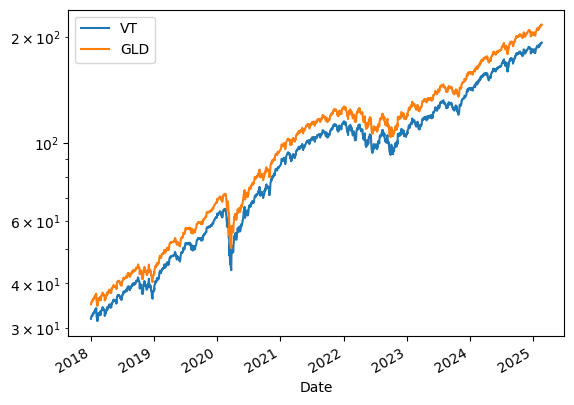

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/485593912.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  216.1433500206124
total tax is  3.3260044127031025


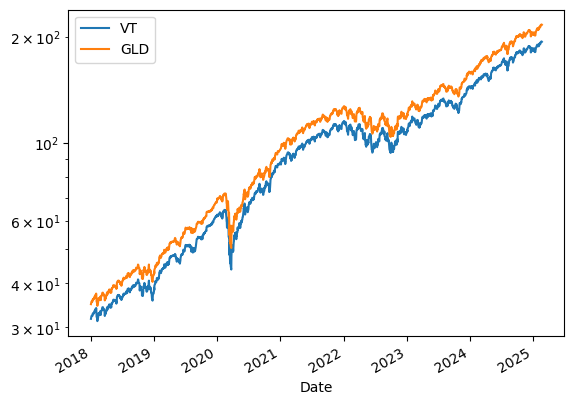

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/485593912.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  216.45799805663432
total tax is  4.024563839804571


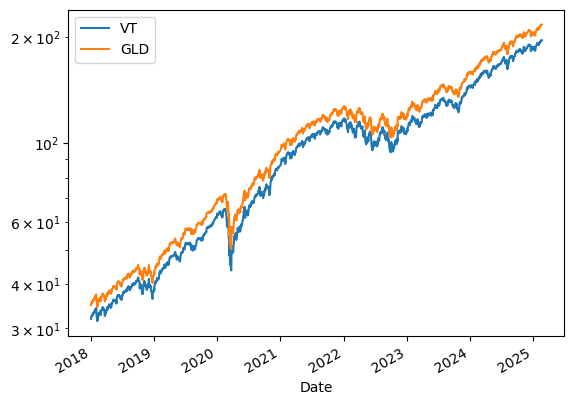

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/485593912.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  216.0548248918008
total tax is  3.2306722633229947


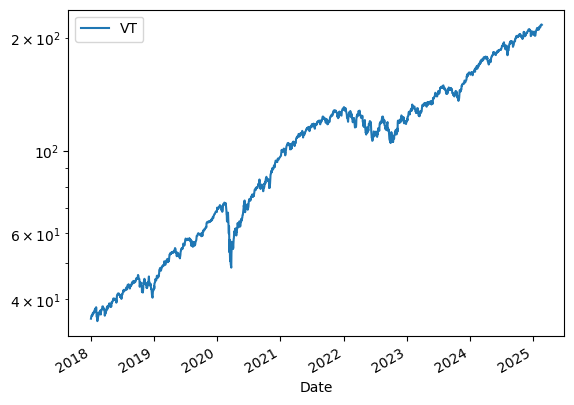

total return is  216.92521683801124
total tax is  3.589635848136661


/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/485593912.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


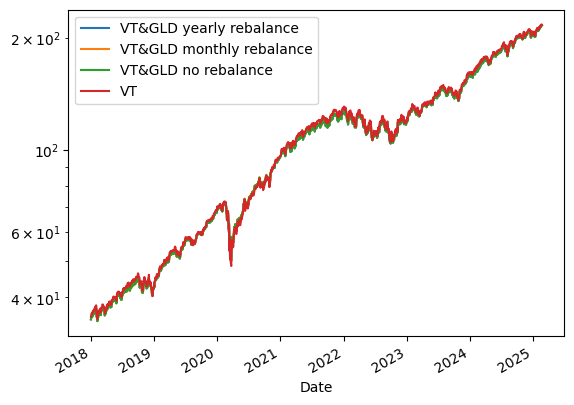

,VT&GLD yearly rebalance,VT&GLD monthly rebalance,VT&GLD no rebalance,VT
Date,,,,
2015-10-22,1.000000,1.000000,1.000000,1.000000
2015-10-23,1.008173,1.008173,1.008173,1.009270
2015-10-26,1.005380,1.005380,1.005380,1.006236
2015-10-27,0.999991,0.999991,0.999991,1.000000
2015-10-28,1.006770,1.006770,1.006770,1.008427
...,...,...,...,...
2025-02-13,215.632487,215.946594,215.544690,216.416454
2025-02-14,215.478578,215.812090,215.441059,216.644515
2025-02-18,216.614951,216.934805,216.537796,217.486608


VT&GLD yearly rebalance


'税'

np.float64(3.3260044127031025)

VT&GLD monthly rebalance


'税'

np.float64(4.024563839804571)

VT&GLD no rebalance


'税'

np.float64(3.2306722633229947)

VT


'税'

np.float64(3.589635848136661)

In [7]:
total_data = {}
buy_histories = {}
all_taxes = {}

for condition in conditions:

    # make generate functions
    portfolio = pd.Series(condition[0])/sum(condition[0].values())
    target_close = close_df[portfolio.keys()]
    target_div = div_rate_df[portfolio.keys()]


    #timestamps = target_close.index
    buy_monthes = condition[1]
    buy_amount = condition[2]
    threshold = condition[3]
    rebalance_monthes = condition[4]
    name = condition[5]
    prev = -1

    result = target_close * 0  # 現在資産
    buy_history = target_close * 0  # 投資記録
    receive_dividends = target_close * 0  # 受け取った税引き後分配金
    taxes = []  # 支払った税金

    #for t in timestamps:
    for t,v in target_div.iterrows():
        if t.month != prev:
            # reset behavior
            bought = False
            rebalanced = False
            prev = t.month
        if t.month in buy_monthes:
            if not bought:
                buy_history.loc[t] += portfolio*buy_amount
                # buy_fundで、今買った投信の将来の値動きをベクタとして取得、ポートフォリオ比率をかけて購入後の値動きを結果時系列に加算
                result = result.add(buy_fund(target_close, t)*portfolio*buy_amount, fill_value=0)  # 現在資産に買った投信を加算
                bought = True
        if t.month in rebalance_monthes:
            if not rebalanced:
                if rebalance_judge(result.loc[t], portfolio, threshold):
                    principle = buy_history.cumsum()
                    sell_buy, tax = rebalance(result.loc[t], principle.loc[t], portfolio)  # リバランスには原価が必要
                    result = result.add(buy_fund(target_close, t)*sell_buy, fill_value=0)  # 現在資産に買った投信を加算
                    buy_history.loc[t] += sell_buy
                    taxes.append(tax)
                rebalanced = True

        # 分配金
        dividends_before = v*result.loc[t]
        dividends_after = dividends_before*(1-TAX_RATE)
        receive_dividends.loc[t] += dividends_after
        result = result.add(buy_fund(target_close, t)*dividends_after, fill_value=0)  # 現在資産に買った投信を加算
        taxes.append((dividends_before*TAX_RATE).sum())

    #div_df = receive_dividends.cumsum()
    #div_df.columns = [col + '_div' for col in div_df.columns]
    #total = pd.concat([result, div_df], axis=1)

    result.loc[datetime.datetime(2018,1,1):].plot(logy=True, stacked=True)
    plt.show()
    plt.close('all')

    print('total return is ', result.sum(axis=1)[-1])
    print('total tax is ', sum(taxes))

    total_data[name] = result.sum(axis=1)
    buy_histories[name] = buy_history
    all_taxes[name] = taxes

pd.DataFrame(total_data).loc[datetime.datetime(2018,1,1):].plot(logy=True)
plt.show()
display(pd.DataFrame(total_data))
for key,df in buy_histories.items():
    print(key)
    display('税', sum(all_taxes[key]))
    #print(df.sum(axis=1).sum())
    #display('購入履歴', df[df!=0].dropna())

### ノーセルリバランスの場合

In [8]:
# 対象の時系列の終値と分配金の時系列を取得する

conditions = [
    [ {'VT': 9.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [3,]  # リバランス頻度 (月のリスト)
    , 'VT&GLD 9:1'  # name
    ],
    [ {'VT': 4.0, 'GLD': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , [1,3,5,7,9,11]  # リバランス頻度 (月のリスト)
    , 'VT&GLD 4:1'  # name
    ],
    [ {'VT': 6.0, 'GLD': 4.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 10  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , []  # リバランス頻度 (月のリスト)
    , 'VT&GLD 6:4'  # name
    ],
    [ {'VT': 1.0 }  # ポートフォリオ {'ticker': rate, }
    , [1,2,3,4,5,6,7,8,9,10,11,12]  # 投資頻度 (月のリスト)
    , 1  # 投資金額
    , 1  # リバランス条件 (最大の乖離ポイントをパーセンタイルで指定)
    , []  # リバランス頻度 (月のリスト)
    , 'VT'  # name
    ],
]

#close_df      # 終値時系列
#dividends_df  # 分配金時系列

# 投資頻度の実装
## 投資タイミングの日を先頭とした時系列を切り出し、その先頭の値で相対化した正規化時系列を生成し、投資金額で乗じたものを、独立した時系列として生成する
## その時系列を積立期間の最後まで生成し続けリストとし、そのリストの和を取る



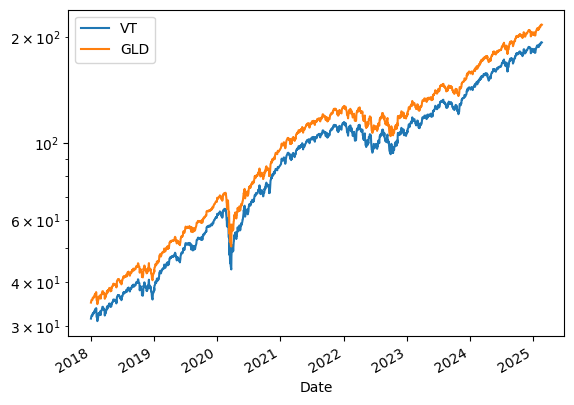

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/212484137.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  217.07947945741137
total tax is  3.185098755381337


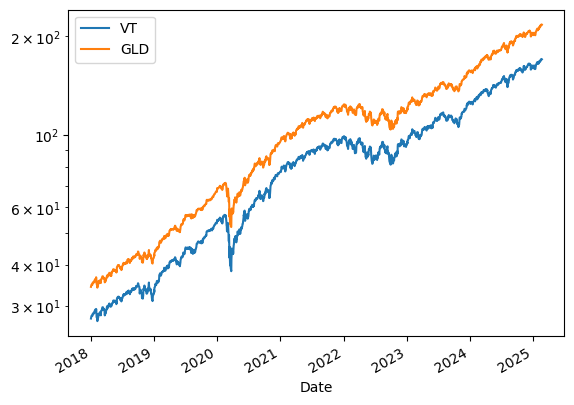

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/212484137.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  217.14094976788272
total tax is  2.7963166551171676


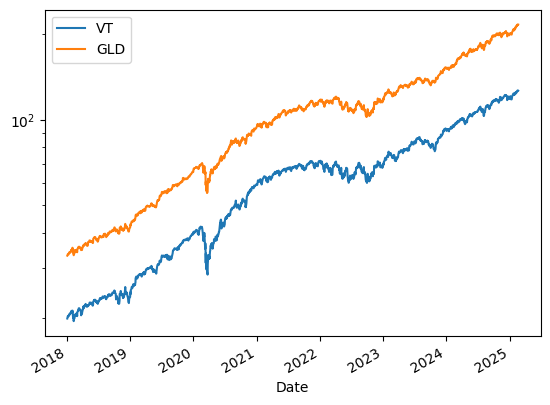

/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/212484137.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


total return is  216.85279479742866
total tax is  2.067501895138267


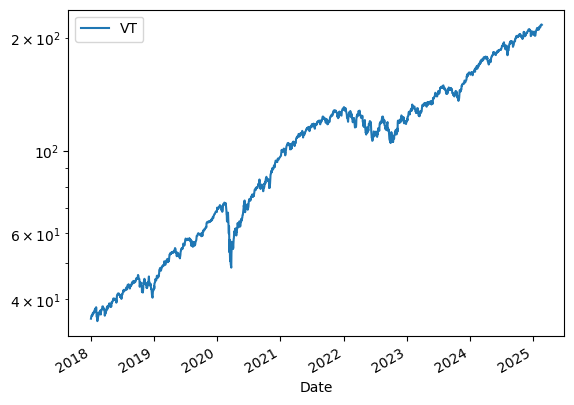

total return is  216.92521683801124
total tax is  3.589635848136661


/var/folders/qb/1x__vlx132q0z6t8nsvyly100000gn/T/ipykernel_83370/212484137.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('total return is ', result.sum(axis=1)[-1])


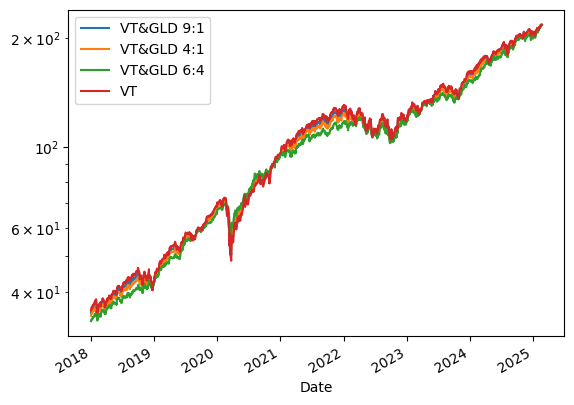

,VT&GLD 9:1,VT&GLD 4:1,VT&GLD 6:4,VT
Date,,,,
2015-10-22,1.000000,1.000000,1.000000,1.000000
2015-10-23,1.008173,1.007076,1.004882,1.009270
2015-10-26,1.005380,1.004524,1.002811,1.006236
2015-10-27,0.999991,0.999982,0.999964,1.000000
2015-10-28,1.006770,1.005112,1.001797,1.008427
...,...,...,...,...
2025-02-13,216.566433,216.623977,216.329418,216.416454
2025-02-14,216.414647,216.105848,215.124985,216.644515
2025-02-18,217.553765,217.531022,217.084156,217.486608


VT&GLD 9:1


'税'

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2341,0.0
2342,0.0
2343,0.0
2344,0.0


'購入履歴'

,VT,GLD
Date,,
2015-10-22,0.900000,0.100000
2015-11-02,0.896349,0.103651
2015-12-01,0.890006,0.109994
2016-01-04,0.913037,0.086963
2016-02-01,0.931932,0.068068
2016-03-01,0.933058,0.066942
2016-04-01,0.867160,0.132840
2016-05-02,0.922510,0.077490
2016-06-01,0.854741,0.145259


VT&GLD 4:1


'税'

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2341,0.0
2342,0.0
2343,0.0
2344,0.0


'購入履歴'

,VT,GLD
Date,,
2015-10-22,0.800000,0.200000
2015-11-02,0.793510,0.206490
2015-12-01,0.782269,0.217731
2016-01-04,0.823060,0.176940
2016-02-01,0.856766,0.143234
2016-03-01,0.859207,0.140793
2016-04-01,0.740889,0.259111
2016-05-02,0.840240,0.159760
2016-06-01,0.718903,0.281097


VT&GLD 6:4


'税'

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2341,0.0
2342,0.0
2343,0.0
2344,0.0


'購入履歴'

,VT,GLD
Date,,
2015-10-22,0.600000,0.400000
2015-11-02,0.590264,0.409736
2015-12-01,0.573511,0.426489
2016-01-04,0.634240,0.365760
2016-02-01,0.685138,0.314862
2016-03-01,0.690117,0.309883
2016-04-01,0.509127,0.490873
2016-05-02,0.661017,0.338983
2016-06-01,0.476450,0.523550


VT


'税'

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2341,0.0
2342,0.0
2343,0.0
2344,0.0


'購入履歴'

,VT
Date,
2015-10-22,1.0
2015-11-02,1.0
2015-12-01,1.0
2016-01-04,1.0
2016-02-01,1.0
...,...
2024-10-01,1.0
2024-11-01,1.0
2024-12-02,1.0


In [18]:
total_data = {}
buy_histories = {}
all_taxes = {}

for condition in conditions:

    # make generate functions
    portfolio = pd.Series(condition[0])
    target_close = close_df[portfolio.keys()]
    target_div = div_rate_df[portfolio.keys()]

    buy_monthes = condition[1]
    portfolio *= condition[2]/portfolio.sum()
    threshold = condition[3]
    rebalance_monthes = condition[4]
    name = condition[5]
    prev = -1

    result = target_close * 0  # 現在資産
    buy_history = target_close * 0  # 投資記録
    receive_dividends = target_close * 0  # 受け取った分配金
    taxes = []  # 支払った税金

    for t,v in target_div.iterrows():
        if t.month != prev:
            # reset behavior
            bought = False
            rebalanced = False
            prev = t.month
        if t.month in buy_monthes:
            if not bought:
                # 現在資産比率に基づき購買比率を決定する
                buy_rate = rebalance_buy(result.loc[t], portfolio, 1)
                buy_history.loc[t] += buy_rate*1
                # buy_fundで、今買った投信の将来の値動きをベクタとして取得、ポートフォリオ比率をかけて購入後の値動きを結果時系列に加算
                result = result.add(buy_fund(target_close, t)*buy_rate*1, fill_value=0)  # 現在資産に買った投信を加算
                bought = True

        # 分配金
        dividends_before = v*result.loc[t]
        dividends_after = dividends_before*(1-TAX_RATE)
        receive_dividends.loc[t] += dividends_after
        result = result.add(buy_fund(target_close, t)*dividends_after, fill_value=0)  # 現在資産に買った投信を加算
        taxes.append((dividends_before*TAX_RATE).sum())

    div_df = receive_dividends.cumsum()
    div_df.columns = [col + '_div' for col in div_df.columns]
    #total = pd.concat([result, div_df], axis=1)

    result.loc[datetime.datetime(2018,1,1):].plot(logy=True, stacked=True)
    plt.show()
    plt.close('all')

    print('total return is ', result.sum(axis=1)[-1])
    print('total tax is ', sum(taxes))

    total_data[name] = result.sum(axis=1)
    buy_histories[name] = buy_history
    all_taxes[name] = taxes

result_df = pd.DataFrame(total_data)
result_df.loc[datetime.datetime(2018,1,1):].plot(logy=True)
plt.show()
display(pd.DataFrame(total_data))
for key,df in buy_histories.items():
    print(key)
    display('税', pd.DataFrame(all_taxes[key]))
    #print(df.sum(axis=1).sum())
    display('購入履歴', df[df!=0].dropna())

In [17]:
principles_df = pd.DataFrame({name: df.sum(axis=1).cumsum() for name, df in buy_histories.items()})
principles_df.iloc[-1]

,VT&GLD 9:1,VT&GLD 4:1,VT&GLD 6:4,VT
Date,,,,
2015-10-22,1.0,1.0,1.0,1.0
2015-10-23,1.0,1.0,1.0,1.0
2015-10-26,1.0,1.0,1.0,1.0
2015-10-27,1.0,1.0,1.0,1.0
2015-10-28,1.0,1.0,1.0,1.0
...,...,...,...,...
2025-02-13,113.0,113.0,113.0,113.0
2025-02-14,113.0,113.0,113.0,113.0
2025-02-18,113.0,113.0,113.0,113.0


In [19]:
result_df.iloc[-1]/principles_df.iloc[-1]

VT&GLD 9:1    1.921057
VT&GLD 4:1    1.921601
VT&GLD 6:4    1.919051
VT            1.919692
Name: 2025-02-20 00:00:00, dtype: float64

# リスクリターン評価

各時系列のシャープレシオを計算する